In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-pre-traitement-sift-bovw-pca/y_labels.npy
/kaggle/input/dataset-pre-traitement-sift-bovw-pca/image_names.pkl
/kaggle/input/dataset-pre-traitement-sift-bovw-pca/label_names.pkl
/kaggle/input/dataset-pre-traitement-sift-bovw-pca/y.npy
/kaggle/input/dataset-pre-traitement-sift-bovw-pca/X_pca.npy


In [2]:
import numpy as np
import pickle
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, hamming_loss
)

In [3]:
# -------------------------------
# 1️ Chargement des données
# -------------------------------
X = np.load("/kaggle/input/dataset-pre-traitement-sift-bovw-pca/X_pca.npy")
y = np.load("/kaggle/input/dataset-pre-traitement-sift-bovw-pca/y.npy")

with open("/kaggle/input/dataset-pre-traitement-sift-bovw-pca/label_names.pkl", "rb") as f:
    label_names = pickle.load(f)

print(X.shape, y.shape)

(8091, 100) (8091, 495)


In [4]:
# -------------------------------
# 2️ MultinomialNB → valeurs ≥ 0
# -------------------------------
X = np.maximum(X, 0)

# -------------------------------
# 3️ Division Train / Test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f" X_train : {X_train.shape} | X_test : {X_test.shape}")
print(f" y_train : {y_train.shape} | y_test : {y_test.shape}")

 X_train : (6472, 100) | X_test : (1619, 100)
 y_train : (6472, 495) | y_test : (1619, 495)


In [5]:
# -------------------------------
# 4️ Configuration MultinomialNB
# -------------------------------
nb_model = OneVsRestClassifier(
    MultinomialNB()
)

param_grid = {
    "estimator__alpha": [
        1e-4, 1e-3, 1e-2, 0.1, 0.5, 1.0
    ]
}

grid_search = GridSearchCV(
    estimator=nb_model,
    param_grid=param_grid,
    scoring="f1_macro",   
    cv=8,
    verbose=2,
    n_jobs=1,
    refit=True
)

In [6]:
# -------------------------------
# 5️ Entraînement
# -------------------------------
print("\n DÉMARRAGE DE L'ENTRAÎNEMENT MULTINOMIAL NB")
start = time.time()

grid_search.fit(X_train, y_train)
best_nb = grid_search.best_estimator_

end = time.time()
print(f" Entraînement terminé en {end - start:.2f} secondes")

print(" Meilleur alpha :", grid_search.best_params_)


 DÉMARRAGE DE L'ENTRAÎNEMENT MULTINOMIAL NB
Fitting 8 folds for each of 6 candidates, totalling 48 fits
[CV] END ............................estimator__alpha=0.0001; total time=   3.4s
[CV] END ............................estimator__alpha=0.0001; total time=   3.4s
[CV] END ............................estimator__alpha=0.0001; total time=   2.1s
[CV] END ............................estimator__alpha=0.0001; total time=   2.2s
[CV] END ............................estimator__alpha=0.0001; total time=   2.0s
[CV] END ............................estimator__alpha=0.0001; total time=   2.1s
[CV] END ............................estimator__alpha=0.0001; total time=   2.0s
[CV] END ............................estimator__alpha=0.0001; total time=   2.2s
[CV] END .............................estimator__alpha=0.001; total time=   2.0s
[CV] END .............................estimator__alpha=0.001; total time=   2.0s
[CV] END .............................estimator__alpha=0.001; total time=   2.0s
[CV]

In [7]:
# -------------------------------
# 6️ Évaluation
# -------------------------------
y_pred = best_nb.predict(X_test)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision_micro": precision_score(y_test, y_pred, average="micro", zero_division=0),
    "Recall_micro": recall_score(y_test, y_pred, average="micro", zero_division=0),
    "F1_macro": f1_score(y_test, y_pred, average="macro", zero_division=0),
    "F1_micro": f1_score(y_test, y_pred, average="micro", zero_division=0),
    "Hamming_Loss": hamming_loss(y_test, y_pred)
}

print("\n MÉTRIQUES DU MODÈLE Naive Bayes - MULTINOMIAL NB :")
for k, v in metrics.items():
    print(f"{k:20s} : {v:.4f}")


 MÉTRIQUES DU MODÈLE Naive Bayes - MULTINOMIAL NB :
Accuracy             : 0.0000
Precision_micro      : 0.0429
Recall_micro         : 0.2064
F1_macro             : 0.0273
F1_micro             : 0.0710
Hamming_Loss         : 0.0475


In [9]:
from sklearn.cluster import KMeans as SegmentationKMeans
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
# Initialisation du binariseur multilabel avec les noms de labels
mlb = MultiLabelBinarizer()
mlb.classes_ = np.array(label_names)
# Fonction pour prédire les labels en appliquant un seuil sur les probabilités
def predict_with_threshold(best_nb, X, threshold=0.3):
    n_samples = X.shape[0]
    n_labels = len(best_nb.estimators_) # Nombre de classifieurs (un par label)
    y_proba = np.zeros((n_samples, n_labels))
    # Calcul des probabilités pour chaque classifieur
    for i, est in enumerate(best_nb.estimators_):
        if hasattr(est, 'predict_proba'):
            proba = est.predict_proba(X)
            # Vérification de la forme pour multiclass ou binaire
            if proba.shape[1] == 2:
                y_proba[:, i] = proba[:, 1]
            else:
                y_proba[:, i] = proba[:, 0]
    # Application du seuil pour obtenir les prédictions binaires
    y_pred = (y_proba >= threshold).astype(int)
    return y_pred, y_proba

# Recherche du meilleur seuil basé sur le rappel (recall)
thresholds = [0.2, 0.3, 0.4, 0.5]
best_threshold = 0.3
best_recall = 0
for t in thresholds:
    y_pred_t, _ = predict_with_threshold(best_nb, X_test, threshold=t)
    # Calcul du recall moyen sur toutes les images
    r = recall_score(y_test, y_pred_t, average='samples', zero_division=0)
    if r > best_recall:
        best_recall = r
        best_threshold = t
print(f"Best threshold: {best_threshold} with recall {best_recall:.4f}")

# Prédictions finales avec le meilleur seuil
y_pred, y_proba = predict_with_threshold(best_nb, X_test, threshold=best_threshold)

Best threshold: 0.2 with recall 0.3127


In [10]:
# Fonction pour générer une phrase gabarit

def generate_sentence_from_keywords(keywords, proba=None):
    # Cas où aucun mot-clé n'est détecté
    if len(keywords) == 0:
        return "No keywords detected"
    # Tri des mots-clés par probabilité si fournie
    if proba is not None:
        keywords = [kw for kw, _ in sorted(zip(keywords, proba), key=lambda x: x[1], reverse=True)]
    # Génération de la phrase selon le nombre de mots-clés    
    if len(keywords) == 1:
        return f"An image of {keywords[0]}"
    elif len(keywords) == 2:
        return f"An image showing {keywords[0]} and {keywords[1]}"
    elif len(keywords) == 3:
        return f"An image of {keywords[0]} with {keywords[1]} and {keywords[2]}"
    else:
        # Si plus de 3 mots-clés, on prend les trois premiers pour la phrase principale
        main_kw = ', '.join(keywords[:3])
        return f"An image featuring {main_kw} and {keywords[3]}"

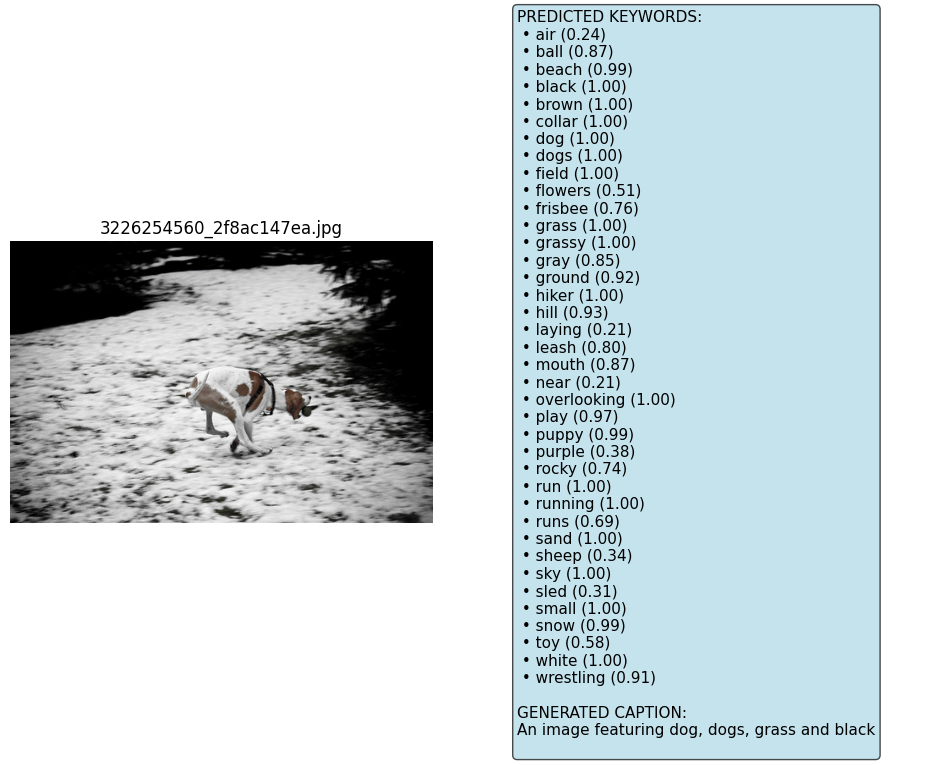

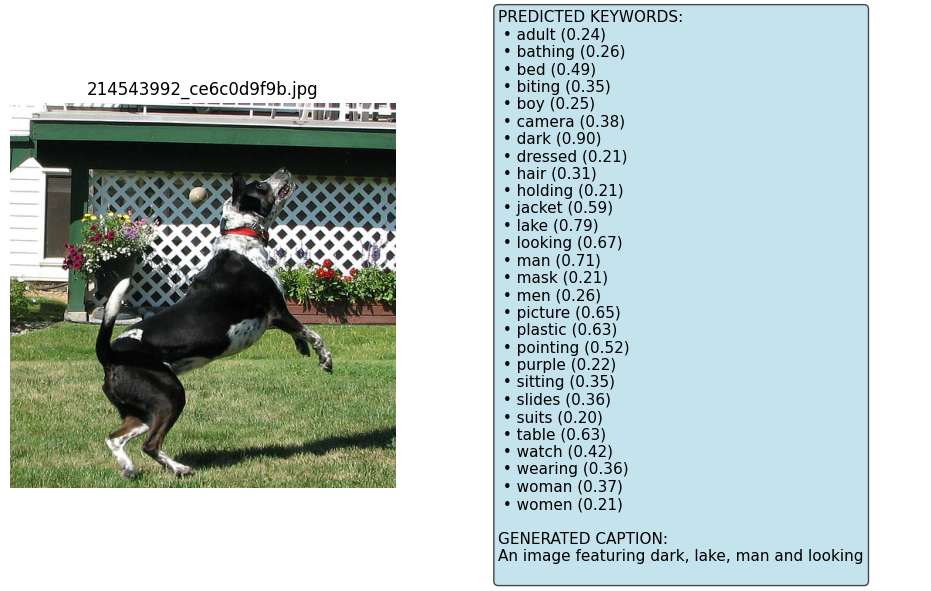

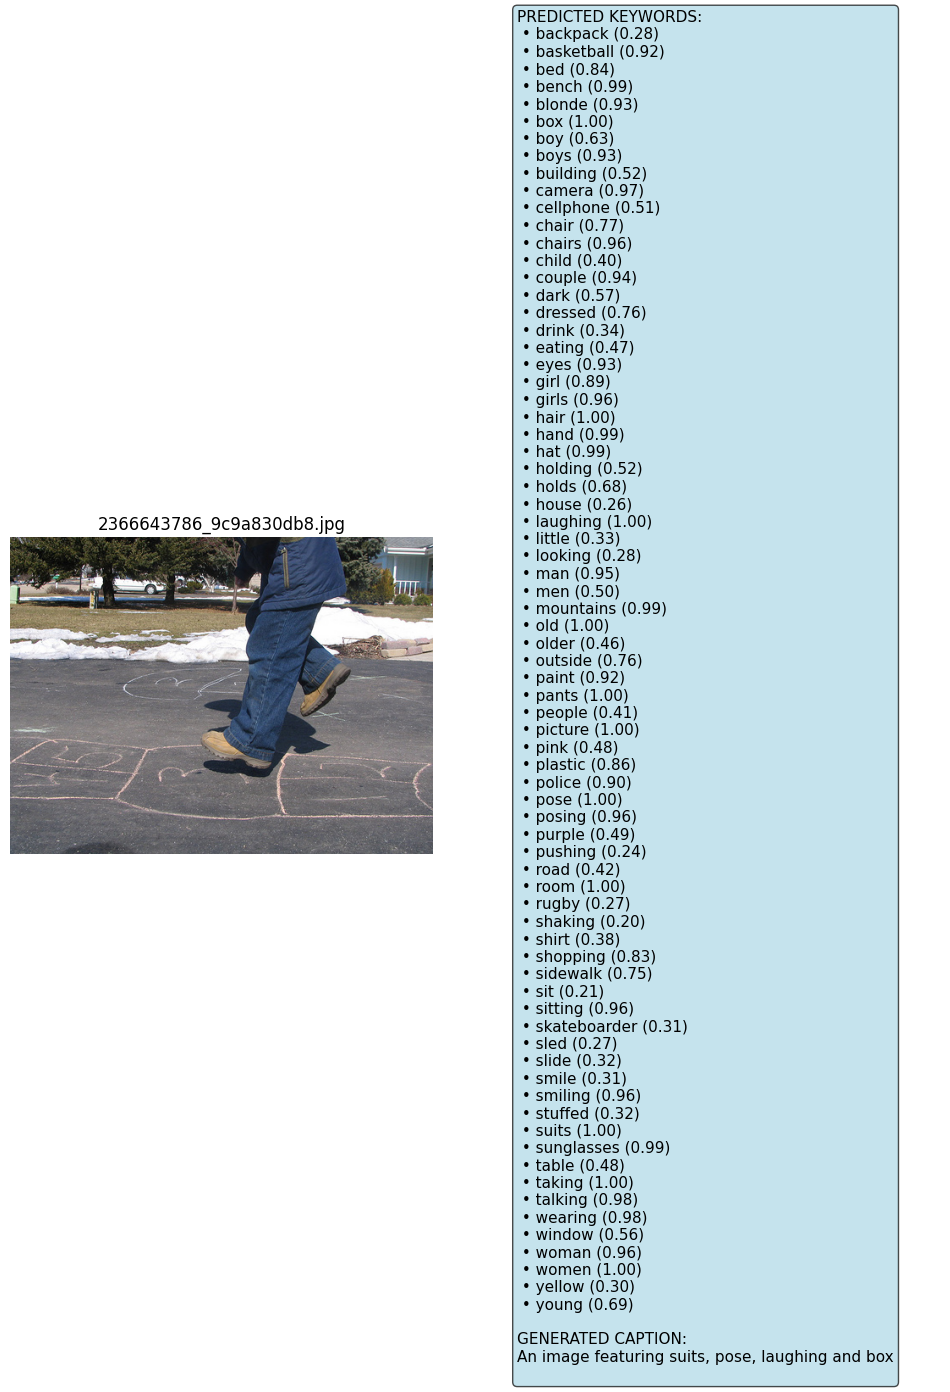

In [11]:
IMAGE_DIR = "/kaggle/input/flickr8k/Images"
# Liste des noms de fichiers d'images valides dans le répertoire
valid_image_names = os.listdir(IMAGE_DIR)

def predict_and_display_improved(idx, X_test, y_test, y_pred, y_proba):
    # Extraction des labels prédits et vrais, ainsi que leurs probabilités
    pred_idx = np.where(y_pred[idx] == 1)[0]
    pred_labels = mlb.classes_[pred_idx]
    pred_probs = y_proba[idx][pred_idx]
    
    true_idx = np.where(y_test[idx] == 1)[0]
    true_labels = mlb.classes_[true_idx]
    
    # Chargement et préparation de l'image
    img_name = valid_image_names[idx]
    img_path = os.path.join(IMAGE_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot load image {img_path}")
        return
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Génération de la légende à partir des mots-clés prédits
    caption = generate_sentence_from_keywords(list(pred_labels), pred_probs)
    
    # Affichage de l'image et des résultats 
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(img_name)
    
    plt.subplot(1,2,2)
    plt.axis('off')
    text = f"PREDICTED KEYWORDS:\n"
    for kw, p in zip(pred_labels, pred_probs):
        text += f" • {kw} ({p:.2f})\n"
    text += f"\nGENERATED CAPTION:\n{caption}\n"
    plt.text(0, 0.5, text, fontsize=11, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    plt.show()
    return pred_labels, caption, true_labels

# Affichage des exemples
for i in range(min(3, len(X_test))):
    predict_and_display_improved(i, X_test, y_test, y_pred, y_proba)

Segmentation avec K-means (k=5)...


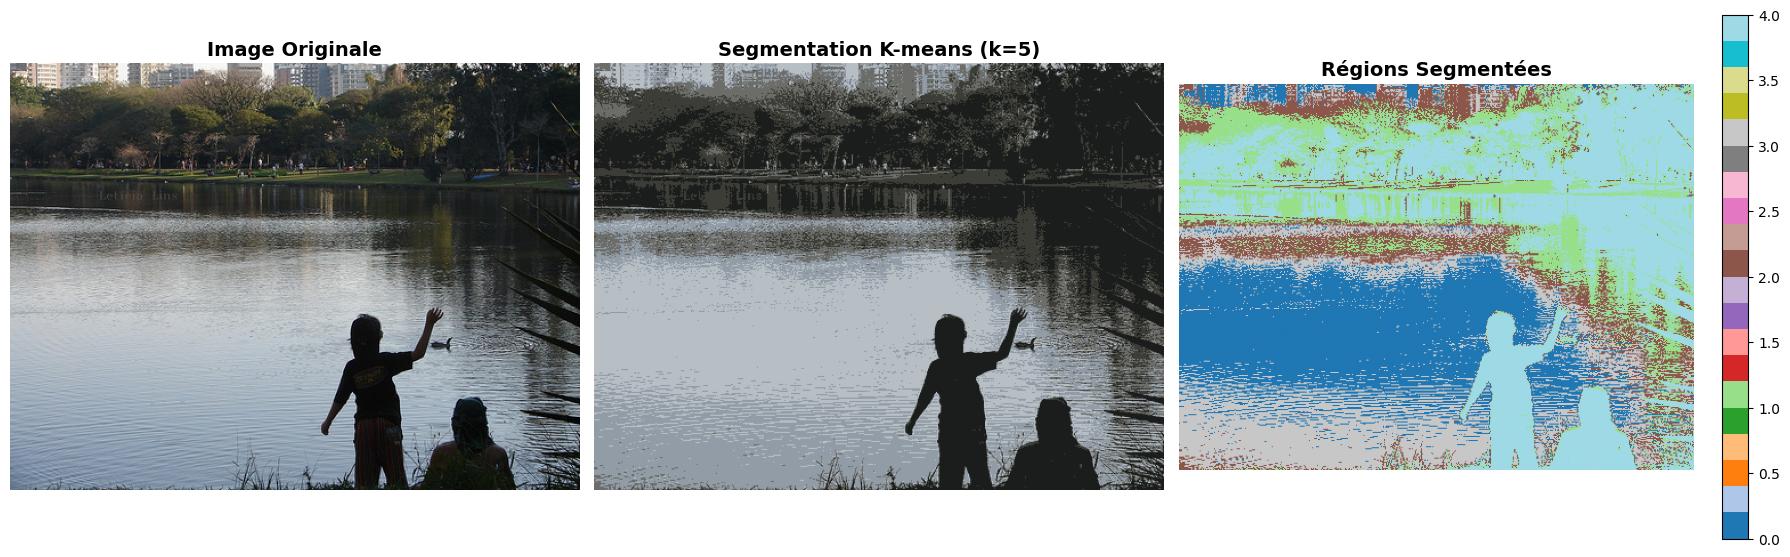


Nombre de segments: 5

Taille des segments (en pixels):
  Segment 0: 45810 pixels (24.43%)
  Segment 1: 29186 pixels (15.57%)
  Segment 2: 21439 pixels (11.43%)
  Segment 3: 36655 pixels (19.55%)
  Segment 4: 54410 pixels (29.02%)


In [12]:
def segment_image_kmeans(image_path, n_segments=5, show_result=True):
    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur: impossible de charger {image_path}")
        return None, None, None
    
    # Convertir BGR -> RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Obtenir les dimensions
    h, w, c = image_rgb.shape
    
    # Reshape: (height, width, 3) -> (height*width, 3)
    pixels = image_rgb.reshape(-1, 3)
    
    # Normaliser les valeurs des pixels [0, 255] -> [0, 1]
    pixels_normalized = pixels.astype(np.float32) / 255.0
    
    # Appliquer K-means
    print(f"Segmentation avec K-means (k={n_segments})...")
    kmeans_seg = SegmentationKMeans(
        n_clusters=n_segments,
        random_state=42,
        n_init=10,
        max_iter=300
    )
    
    labels = kmeans_seg.fit_predict(pixels_normalized)
    centers = kmeans_seg.cluster_centers_
    
    # Reconstruire l'image segmentée avec les centres de clusters
    segmented_pixels = centers[labels]
    segmented_image = (segmented_pixels * 255).reshape(h, w, c).astype(np.uint8)
    
    # Reshape labels pour avoir la forme de l'image
    labels_image = labels.reshape(h, w)
    
    if show_result:
        # Affichage
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Image originale
        axes[0].imshow(image_rgb)
        axes[0].set_title('Image Originale', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        # Image segmentée
        axes[1].imshow(segmented_image)
        axes[1].set_title(f'Segmentation K-means (k={n_segments})', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        # Labels (régions)
        im = axes[2].imshow(labels_image, cmap='tab20')
        axes[2].set_title('Régions Segmentées', fontsize=14, fontweight='bold')
        axes[2].axis('off')
        plt.colorbar(im, ax=axes[2], fraction=0.046)
        
        plt.tight_layout()
        plt.show()
        
        # Statistiques
        unique_labels, counts = np.unique(labels, return_counts=True)
        print(f"\nNombre de segments: {len(unique_labels)}")
        print("\nTaille des segments (en pixels):")
        for label, count in zip(unique_labels, counts):
            percentage = (count / len(labels)) * 100
            print(f"  Segment {label}: {count} pixels ({percentage:.2f}%)")
    
    return segmented_image, labels_image, centers
    
seg_img1, labels1, centers1 = segment_image_kmeans(
    "/kaggle/input/flickr8k/Images/1022454332_6af2c1449a.jpg", 
    n_segments=5, 
    show_result=True
)

In [13]:
accuracy = accuracy_score(y_test, y_pred)
f1_samples = f1_score(y_test, y_pred, average='samples', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
recall_samples = recall_score(y_test, y_pred, average='samples', zero_division=0)
precision_samples = precision_score(y_test, y_pred, average='samples', zero_division=0)
hamming = hamming_loss(y_test, y_pred)

print("\nMesures de classification:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 (samples): {f1_samples:.4f}")
print(f"F1 (macro): {f1_macro:.4f}")
print(f"F1 (micro): {f1_micro:.4f}")
print(f"Recall (samples): {recall_samples:.4f}")
print(f"Precision (samples): {precision_samples:.4f}")
print(f"Hamming Loss: {hamming:.4f}")


Mesures de classification:
Accuracy: 0.0000
F1 (samples): 0.0789
F1 (macro): 0.0286
F1 (micro): 0.0724
Recall (samples): 0.3127
Precision (samples): 0.0483
Hamming Loss: 0.0702


In [14]:
def calculate_bleu_scores(ref, hyp):
    # Fonction interne pour générer les n-grams d'une liste de tokens
    def ngrams(tokens, n):
        return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    scores = []
    # Calcul des BLEU-1 à BLEU-4
    for n in range(1,5):
        ref_ngrams = ngrams(ref, n) # n-grams de la référence
        hyp_ngrams = ngrams(hyp, n) # n-grams de la prédiction
        if len(hyp_ngrams)==0:
            scores.append(0)
        else:
            # Comptage des n-grams communs entre référence et prédiction
            overlap = sum(1 for g in hyp_ngrams if g in ref_ngrams)
            scores.append(overlap/len(hyp_ngrams))
    return scores

def calculate_cider_score(ref_kw, hyp_kw):
    if len(ref_kw)==0 or len(hyp_kw)==0:
        return 0 # Cas où l'un des ensembles est vide
    # Compteurs de fréquence des mots    
    ref_counter = Counter(ref_kw)
    hyp_counter = Counter(hyp_kw)
    all_words = set(ref_kw) | set(hyp_kw)
    # Création des vecteurs de fréquence pour référence et prédiction
    ref_vec = {w: ref_counter.get(w,0) for w in all_words}
    hyp_vec = {w: hyp_counter.get(w,0) for w in all_words}
    # Calcul du produit scalaire et de la norme pour la similarité cosinus
    dot = sum(ref_vec[w]*hyp_vec[w] for w in all_words)
    norm = (sum(v*v for v in ref_vec.values())**0.5) * (sum(v*v for v in hyp_vec.values())**0.5)
    # Retour du score CIDEr (normalisé sur 10)
    return (dot/norm)*10 if norm>0 else 0

bleu1_scores, bleu2_scores, bleu3_scores, bleu4_scores, cider_scores = [], [], [], [], []

for i in range(len(X_test)):
    # Extraction des mots-clés prédits et vrais
    pred_idx = np.where(y_pred[i]==1)[0]
    pred_kw = list(mlb.classes_[pred_idx])
    true_idx = np.where(y_test[i]==1)[0]
    true_kw = list(mlb.classes_[true_idx])
    # Calcul des scores BLEU
    b1, b2, b3, b4 = calculate_bleu_scores(true_kw, pred_kw)
    bleu1_scores.append(b1)
    bleu2_scores.append(b2)
    bleu3_scores.append(b3)
    bleu4_scores.append(b4)
    # Calcul du score CIDEr
    cider_scores.append(calculate_cider_score(true_kw, pred_kw))

print("\nCaption Metrics:")
print(f"BLEU-1: {np.mean(bleu1_scores):.4f}")
print(f"BLEU-2: {np.mean(bleu2_scores):.4f}")
print(f"BLEU-3: {np.mean(bleu3_scores):.4f}")
print(f"BLEU-4: {np.mean(bleu4_scores):.4f}")
print(f"CIDEr: {np.mean(cider_scores):.4f}")


Caption Metrics:
BLEU-1: 0.0483
BLEU-2: 0.0027
BLEU-3: 0.0003
BLEU-4: 0.0000
CIDEr: 1.1659
